# Interactive Eye Gaze Analysis Pipeline 

This notebook demonstrates how to use the utility functions in `eye_gaze_utils.py` to process and analyze eye tracker data. 

In addition to setting up the environment using the requirements.txt file, this notebook requires the following: 
- Install R from [https://www.r-project.org/](https://www.r-project.org/)
- Install the following R packages:
    - `lmerTest` (for mixed-effects modeling)
    - `emmeans` (for estimated marginal means and pairwise comparisons)

## 1. Normalize the data and then calculate various eye_gaze metrics
Import utilities from `eye_gaze_utils.py`:

In [1]:
from eye_gaze_utils import load_file_data, normalize_gaze_to_screen, extract_eye_metrics, plot_data
import os
import pandas as pd

Set the data directory and find all the csv files containing the eye gaze data:

In [2]:
# Set the directory containing your eye tracker CSV files

# Prompt the user to input the PNAS-MATB folder path
directory = input("Enter the full path to your PNAS-MATB folder: ")
eyelink_directory = os.path.join(directory, "eyelink_data")

# List available CSV files
eye_files = [f for f in os.listdir(eyelink_directory) if f.endswith('.csv')]
print(f"Found {len(eye_files)} files. Example: {eye_files[:3]}")

Found 129 files. Example: ['3105_session01.csv', '3105_session02.csv', '3105_session03.csv']


Load and preprocess a single file as an example:

In [3]:
# Load and normalize data from the first file
example_file = eye_files[0]
file_data = load_file_data(eyelink_directory, example_file)
if file_data is not None:
    original_df = file_data['data']
    filtered_df = normalize_gaze_to_screen(original_df.copy())
    print(f"Loaded and normalized: {example_file}")
else:
    print(f"Failed to load {example_file}")

Loaded and normalized: 3105_session01.csv


Plot original versus normalized gaze and pupil data:

Plotting data...


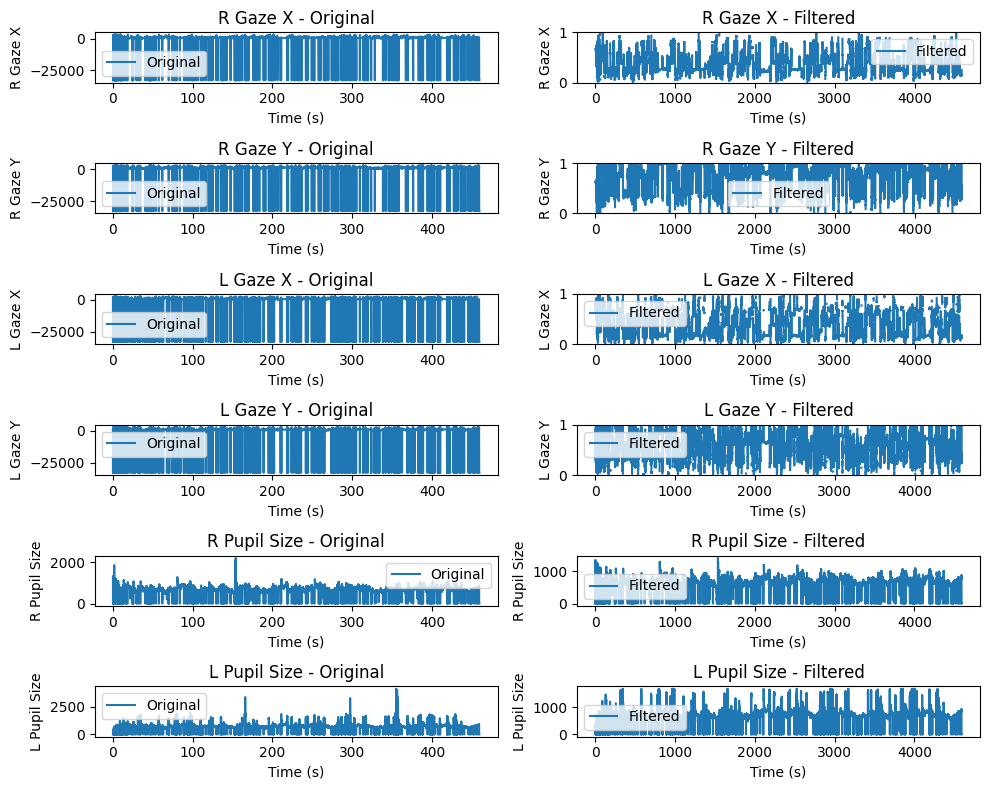

In [5]:
columns_to_plot = ['R Gaze X', 'R Gaze Y', 'L Gaze X', 'L Gaze Y', 'R Pupil Size', 'L Pupil Size']
if file_data is not None:
    plot_data(original_df, filtered_df, columns_to_plot, filename=example_file, dir=directory, save=False)

Extract windowed eye metrics from the filtered data:

In [8]:
if file_data is not None:
    metrics_df = extract_eye_metrics(filtered_df)
    display(metrics_df.head(10))

,window_index,start_time,end_time,pct_missing,mean_vel,max_vel,mean_acc,rms_disp,fix_count,fix_mean_dur,fix_rate,blink_count,blink_mean_dur,blink_rate,sac_count,sac_mean_dur,sac_rate
0,0,0.000000,59.999640,13.745693,3.639736,791.744404,-0.496224,0.331632,95,0.306633,1.583343,154,0.045651,2.566682,2597,0.002442,43.283593
1,1,30.000807,89.999184,7.914860,1.930696,692.831896,-0.132645,0.324914,98,0.340372,1.633378,78,0.056745,1.300035,2429,0.002401,40.484429
2,2,60.000679,119.999572,6.170861,2.080252,692.831896,-0.426292,0.333323,83,0.368687,1.383359,98,0.033114,1.633363,2531,0.002407,42.184111
3,3,90.000233,149.999192,8.719280,1.955017,570.931726,-0.336506,0.322423,88,0.382451,1.466692,83,0.038468,1.383357,2560,0.002391,42.667407
4,4,120.000612,179.999751,12.425510,2.126065,680.929601,-0.155006,0.332110,92,0.364224,1.533355,62,0.060486,1.033348,2652,0.002388,44.200634
5,5,150.000230,209.999171,9.737410,2.257979,680.929601,-0.052700,0.340624,104,0.290447,1.733364,72,0.053981,1.200021,2727,0.002400,45.450802
6,6,180.000796,239.999192,7.678519,1.836298,651.258325,-0.078367,0.318730,91,0.357587,1.516707,49,0.056991,0.816688,2579,0.002378,42.984482
7,7,210.000212,269.999547,8.078644,1.792998,714.155133,-0.125454,0.300379,82,0.445994,1.366682,51,0.073325,0.850009,2621,0.002355,43.683817
8,8,240.000239,299.999529,8.568540,2.168920,714.155133,0.144086,0.321898,94,0.350498,1.566685,59,0.072405,0.983345,2693,0.002359,44.883864
9,9,270.000595,329.999799,7.825951,2.093715,650.565021,-0.140084,0.325339,90,0.356306,1.500020,48,0.059112,0.800011,2629,0.002370,43.817249


Process all files and generate a single dataframe of metrics for all participants:

In [6]:
all_metrics = []
for fname in eye_files:
    file_data = load_file_data(eyelink_directory, fname)
    if file_data is not None:

        # Normalize data and extract metrics
        df = file_data['data']
        filtered_df = normalize_gaze_to_screen(df.copy())
        metrics_df = extract_eye_metrics(filtered_df)

        # Add file/participant/session info to each row
        metrics_df['file_name'] = fname
        metrics_df['participant_id'] = file_data.get('participant_id', None)
        metrics_df['session_number'] = file_data.get('session_number', None)
        all_metrics.append(metrics_df)

# Combine all metrics into a single DataFrame
if all_metrics:
    all_metrics_df = pd.concat(all_metrics, ignore_index=True)
    print("Processed all files!")
else:
    print("No valid files processed.")

Processed all files!


Save data for further analysis. Skip if you want to just get the stats results and plots:

In [7]:
output_csv = os.path.join('..', 'rf_training_data', 'eyegaze_metrics.csv')
all_metrics_df.to_csv(output_csv, index=False)
print(f"Saved all metrics to {output_csv}")

Saved all metrics to ..\rf_training_data\eyegaze_metrics.csv


## 2. Run stats and plot figures using `stats_figures.py` utilities

Import relevant libraries and set the metrics for analysis (Blink rate and Fixation rate):

In [8]:
import sys
sys.path.append('..')  # Add parent directory
from stats_figures import run_rpy2_lmer, barplot_ax
import matplotlib.pyplot as plt

# Define relevant metrics and labels
metrics = [
    ("blink_count", "Blink rate (blinks/min)"),
    ("fix_count", "Fixation rate (fixations/min)")
]

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


Load session info for all participants and add relevant dependent variables to all_metrics_df:

In [9]:
# Load session information
Session_Info = pd.read_csv(
    os.path.join(directory,"participant_info.csv")
)
# Add session_order column to Session_Info
if {"session01", "session02", "session03"}.issubset(Session_Info.columns):
    Session_Info["session_order"] = (
        Session_Info["session01"].str[0] +
        Session_Info["session02"].str[0] +
        Session_Info["session03"].str[0]
    )

# Map 'condition' from Session_Info to all_metrics_df using participant_id and session_number
def get_condition(row):
    pid = int(row['participant_id'])
    session_col = f"session{row['session_number']}"
    if pid in Session_Info["Participant ID"].values and session_col in Session_Info.columns:
        cond = Session_Info.loc[Session_Info["Participant ID"] == pid, session_col].values
        if len(cond) > 0:
            return cond[0]
    return None
all_metrics_df["condition"] = all_metrics_df.apply(get_condition, axis=1)
# Prepare session_order and session_order_numeric maps
session_order_numeric_map = {"LMH": 1, "LHM": 2}
# Map session_order_numeric from Session_Info to all_metrics_df using participant_id
if "session_order" in Session_Info.columns:
    session_info_numeric_map = Session_Info.set_index("Participant ID")["session_order"].map(session_order_numeric_map).to_dict()
    all_metrics_df["session_order_numeric"] = all_metrics_df["participant_id"].astype(int).map(session_info_numeric_map)

Run stats and make plots for the metrics of interest:


--- Blink rate (blinks/min) ---
Means for blink_count:
  H: 39.954
  L: 29.073
  M: 33.970
  participant_id condition  session_order_numeric  window_index  blink_count
0           3105         L                    1.0           0.0        154.0
1           3105         L                    1.0           1.0         78.0
2           3105         L                    1.0           2.0         98.0
3           3105         L                    1.0           3.0         83.0
4           3105         L                    1.0           4.0         62.0

=== Blink rate (blinks/min) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: blink_count ~ condition + session_order_numeric + window_index +  
    (1 | participant_id)
   Data: dat

REML criterion at convergence: 16793.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0665 -0.4784 -0.1195  0.2957 13.4959 

Random effects:
 Groups         Name        Variance Std.

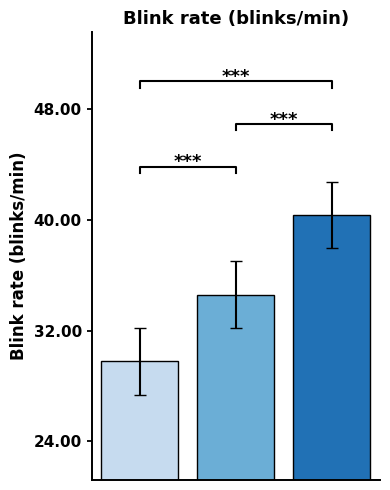


--- Fixation rate (fixations/min) ---
Means for fix_count:
  H: 78.420
  L: 80.718
  M: 79.058
  participant_id condition  session_order_numeric  window_index  blink_count
0           3105         L                    1.0           0.0        154.0
1           3105         L                    1.0           1.0         78.0
2           3105         L                    1.0           2.0         98.0
3           3105         L                    1.0           3.0         83.0
4           3105         L                    1.0           4.0         62.0

=== Fixation rate (fixations/min) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fix_count ~ condition + session_order_numeric + window_index +  
    (1 | participant_id)
   Data: dat

REML criterion at convergence: 14441.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.7630 -0.6155 -0.0009  0.6338  4.6340 

Random effects:
 Groups         Name        Varia

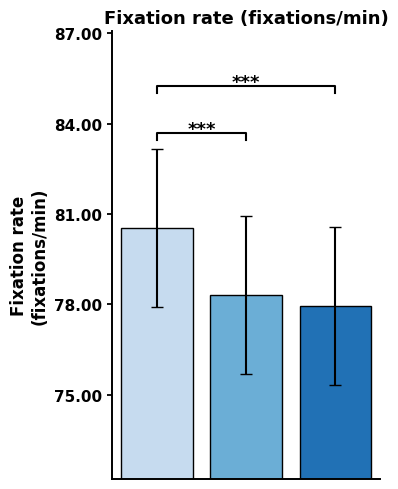

In [10]:
# Use the all_metrics_df from previous cell
if 'all_metrics_df' in locals():
    for metric, label in metrics:
        print(f"\n--- {label} ---")
        # Run mixed effects model and get stats
        pairwise_p, means, cis = run_rpy2_lmer(
            all_metrics_df, metric, label
        )
        # Prepare data for plotting
        conds = ["L", "M", "H"]
        mean_vals = [means.get(c, float('nan')) for c in conds]
        sems = [(cis[c][1] - cis[c][0]) / 3.92 if c in cis else float('nan') for c in conds]  # 95% CI to SEM
        pvals = [pairwise_p.get(("L", "M"), 1.0), pairwise_p.get(("L", "H"), 1.0), pairwise_p.get(("M", "H"), 1.0)]
        # Plot
        fig, ax = plt.subplots(figsize=(4, 5))
        barplot_ax(ax, mean_vals, sems, pvals, ylabel=label, metric_name=metric)
        ax.set_title(label, fontsize=13, weight='bold')
        plt.tight_layout()
        plt.show()
else:
    print("all_metrics_df not found. Please run the previous cell to generate metrics.")